## Object: predict the 'mpg’ for a car using the dataset

In [2]:
import pandas as  pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.model_selection import KFold
from sklearn import model_selection
import math

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
df = pd.read_csv("assignment4.csv")
df[:5]

,Unnamed: 0,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
0,0,18.0,8,307.0,130.0,3504,12.0,70,1
1,1,15.0,8,350.0,165.0,3693,11.5,70,1
2,2,18.0,8,318.0,150.0,3436,11.0,70,1
3,3,16.0,8,304.0,150.0,3433,12.0,70,1
4,4,17.0,8,302.0,140.0,3449,10.5,70,1


In [4]:
y = df['mpg']
x = df.drop(['mpg','Unnamed: 0'], axis = 1)
y.shape
x.shape

(398,)

(398, 7)

### Q1 Build Lasso model
 Using the dataset, create Lasso regression models to predict the ‘mpg’ for a car using 20% and 80% of the training data for the 2 models.

In [5]:
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(x, y, test_size = 0.2, random_state = 42)
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(x, y, test_size = 0.8, random_state = 42)

In [6]:
lasso = linear_model.Lasso(normalize=False)
model_1 = lasso.fit(x_train_1, y_train_1)
model_2 = lasso.fit(x_train_2, y_train_2)

The model with 80% of test data gives lower R square and larger mean squared error, which is reasonable.

In [7]:
## the R-score of the models
pred_1 = model_1.predict(x_test_1)
pred_2 = model_2.predict(x_test_2)
score_1 = model_1.score(x_test_1, y_test_1)
score_2 = model_2.score(x_test_2, y_test_2)
score_1, score_2

(0.805534185880104, 0.7895974581116371)

In [8]:
# the mean squared error of the models
from sklearn.metrics import mean_squared_error
mean_squared_error(pred_1, y_test_1), mean_squared_error(pred_2, y_test_2)

(10.455735256175346, 12.899885973839295)

In [9]:
# the coefficients of the models
model_1.coef_, model_2.coef_

(array([-0.        , -0.00562763, -0.02435025, -0.00598054,  0.        ,
         0.61970055, -0.        ]),
 array([-0.        , -0.00562763, -0.02435025, -0.00598054,  0.        ,
         0.61970055, -0.        ]))

In [10]:
import matplotlib.pyplot as plt
def plot_model(y_true, y_pred):
    x_ax = range(len(y_true))
    plt.scatter(x_ax, y_true, s=5, color="blue", label="original")
    plt.plot(x_ax, y_pred, lw=0.8, color="red", label="predicted")
    plt.legend()
    plt.show()

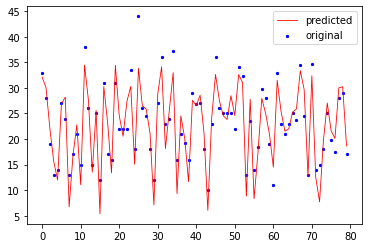

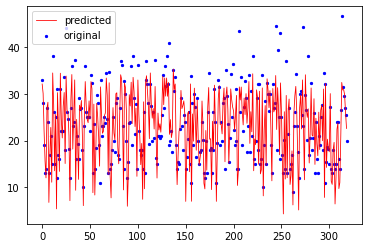

In [11]:
# plot the prediction
plot_model(y_test_1, pred_1)
plot_model(y_test_2, pred_2)

### Q2 Selecting Lasso via AIC, BIC

Using LassoLarsIC to choose the alpha that minimizes the AIC, BIC score.

In [12]:
from sklearn.linear_model import LassoLarsIC

lasso_aic = LassoLarsIC(criterion = "aic", normalize=False)
lasso_aic.fit(x_train_1, y_train_1)
lasso_bic = LassoLarsIC(criterion = "bic", normalize=False)
lasso_bic.fit(x_train_1, y_train_1)

results = pd.DataFrame(
{
    "alphas": lasso_aic.alphas_,
    "AIC criterion": lasso_aic.criterion_,
    "BIC criterion": lasso_bic.criterion_
}).set_index("alphas")

def highlight_min(x):
    x_min = x.min()
    return ["font-weight: bold" if v == x_min else "" for v in x]


results.style.apply(highlight_min)

LassoLarsIC(normalize=False)

LassoLarsIC(criterion='bic', normalize=False)

,AIC criterion,BIC criterion
alphas,,
5498.137864404097,318.000000,318.000000
29.9100311325332,102.341862,106.103913
15.317601984549334,102.509917,110.034020
8.671283499242495,102.507170,113.793325
1.4594024648173651,69.429610,80.715764
0.5749674799607084,68.629396,79.915550
0.47722511900920256,70.578361,85.626566
0.23634831843467718,70.068392,88.878649
0.03600885230687332,71.195057,93.767365


Text(0.5, 0, '$\\alpha$')

Text(0, 0.5, 'criterion')

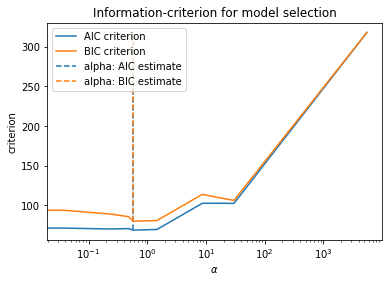

In [13]:
alpha_aic = lasso_aic.alpha_
alpha_bic = lasso_bic.alpha_
ax = results.plot()
ax.vlines(
    alpha_aic,
    results["AIC criterion"].min(),
    results["AIC criterion"].max(),
    label="alpha: AIC estimate",
    linestyles="--",
    color="tab:blue",
)
ax.vlines(
    alpha_bic,
    results["BIC criterion"].min(),
    results["BIC criterion"].max(),
    label="alpha: BIC estimate",
    linestyle="--",
    color="tab:orange",
)
ax.set_xlabel(r"$\alpha$")
ax.set_ylabel("criterion")
ax.set_xscale("log")
ax.legend()
_ = ax.set_title(
    f"Information-criterion for model selection"
)

Build the lasso regression model using alpha that minimizes AIC and BIC:

In [14]:
min_alpha = results['AIC criterion'].min()
lasso_best = linear_model.Lasso(alpha=min_alpha, normalize=False)
model_1_r = lasso_best.fit(x_train_1, y_train_1)
model_2_r = lasso_best.fit(x_train_2, y_train_2)
score_1_r = model_1_r.score(x_test_1, y_test_1)
score_2_r = model_2_r.score(x_test_2, y_test_2)
score_1_r, score_2_r
score_1, score_2

(0.7229777891046785, 0.6914304963592831)

(0.805534185880104, 0.7895974581116371)

View from the result above, after applying the best alpha, the two models' R square value increased by 8% and 9% respectively.

### Q3 Simple regression model with cross validation

In [15]:
lm = linear_model.LinearRegression()
folds = KFold(n_splits = 10, shuffle = True, random_state = 42)
scores_1 = model_selection.cross_val_score(lm, x_train_1, y_train_1, scoring = 'r2', cv = folds)
scores_2 = model_selection.cross_val_score(lm, x_train_2, y_train_2, scoring = 'r2', cv = folds)
scores_1, scores_2

(array([0.76408233, 0.878252  , 0.74826606, 0.7842487 , 0.76867413,
        0.83045557, 0.79895091, 0.75353271, 0.79874784, 0.82806524]),
 array([0.01215688, 0.81145597, 0.7149997 , 0.71903632, 0.39156655,
        0.90644618, 0.81453197, 0.39169906, 0.86669767, 0.74193072]))

For the model 2, it has a train-test set with R square over 91%, which is much more higher than lasso regression result. Overall cross validation seems to give better results in R square.

In [16]:
# predictions of cv
pred_cv = model_selection.cross_val_predict(lm, x, y, cv = folds)

(array([ 3.,  1.,  4.,  3., 13.,  8., 11.,  8.,  9., 13., 11., 13.,  6.,
        12., 24., 18., 22., 20., 17., 29., 24., 16., 23., 16., 21., 20.,
         8., 10.,  7.,  8.]),
 array([ 5.87420667,  6.89907521,  7.92394375,  8.94881229,  9.97368083,
        10.99854937, 12.02341791, 13.04828645, 14.07315499, 15.09802353,
        16.12289207, 17.14776061, 18.17262915, 19.19749769, 20.22236623,
        21.24723477, 22.27210331, 23.29697185, 24.32184039, 25.34670894,
        26.37157748, 27.39644602, 28.42131456, 29.4461831 , 30.47105164,
        31.49592018, 32.52078872, 33.54565726, 34.5705258 , 35.59539434,
        36.62026288]),
 <BarContainer object of 30 artists>)

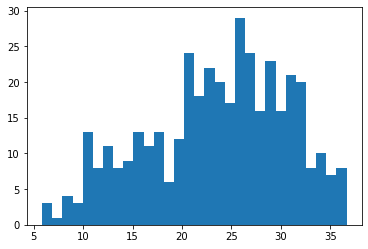

In [28]:
plt.hist(pred_cv, bins =30)
plt.show()

Viewing from the plot directly, there seems to exists heteroskedasticity problem as variance becomes smaller as y range increases.

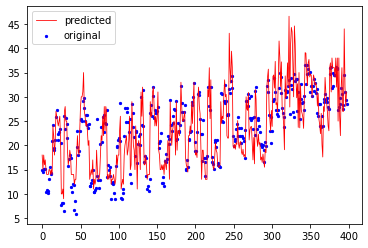

In [27]:
plot_model(pred_cv, y)

### Q4 AIC, AICc, BIC for lasso and simple linear regression

Is BIC always greater than AIC?  When log(n)>2, i.e., when n > e^2, BIC will be larger. So in most cases BIC > AIC. 

In [18]:
def get_metrics(n, mse, k):
    '''
    n: number of observations
    mse: mean square error
    k: number of parameters
    '''
    AIC = n * math.log(mse) + 2 * k
    AICc = AIC + (2 * k * (k + 1))/(n - k - 1)
    BIC = n * math.log(mse) + math.log(n) * k
    
    return 'AIC:{},  AICc:{},  BIC:{}'.format(AIC, AICc, BIC)


In [19]:
# q1 mse
q1_1_mse = 10.455735256175346
q1_2_mse = 12.899885973839295
q1_n1 = x_train_1.shape[0]
q1_n2 = x_train_2.shape[0]

# q2 mse
q2_pred_1 = lasso_best.predict(x_test_1)
q2_pred_2 = lasso_best.predict(x_test_2)
q2_1_mse = mean_squared_error(q2_pred_1, y_test_1)
q2_2_mse = mean_squared_error(q2_pred_2, y_test_2)
q2_n1 = q1_n1
q2_n2 = q1_n2

# q3 mse
q3_mse = mean_squared_error(pred_cv, y)
q3_n = pred_cv.shape[0]

k = 7

In [20]:
q2_1_mse
q2_2_mse

14.894499119603944

18.91855191598136

$AICc = AIC + \frac{2k^2+2k}{n-k-1}$, when n is large, AICc converges to AIC. AIC in our case is very close to AICc, as our sample is large enough.

In [21]:
get_metrics(q1_n1, q1_1_mse, k)
get_metrics(q1_n2, q1_2_mse, k)
get_metrics(q3_n, q3_mse, k)

'AIC:760.3939086721615,  AICc:760.7551989947422,  BIC:786.7282683516228'

'AIC:216.02025929521238,  AICc:217.59772408394477,  BIC:232.60639426248153'

'AIC:985.4919545084712,  AICc:985.7791339956507,  BIC:1013.3971185454623'

And our lasso model with best alpha gives AIC = 68.629396 and BIC = 79.915550. So the lasso model with alpha = 0.5749674799607084 is the best.
